<a href="https://colab.research.google.com/github/26medias/TF-Face-Angle-Translation/blob/master/Face_Position_Dataset_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Position Dataset Viewer

This notebook explores the Face Position dataset.

The dataset is created by extracting & clustering faces from movie trailers.

For each face, the dataset contains:
- Trailer Name
- Group number (identical faces belong to identical group numbers)
- 224x224 JPG cropped face
- Embedding vector (use cosine distance to match similar faces by their embedding)
- Facial Landmarks (list of (x,y) on the cropped face)
- Facial Segmentation

This dataset was generated using this notebook:

https://colab.research.google.com/drive/1oTcS0DGzz9i4fB5wxf6er9gymxJVfq5l



## Download & unpack the dataset

In [0]:
!wget https://storage.googleapis.com/tf-face-angle-translation/datasets/faces-clustered-720p-large.tar.gz
!tar -xzf faces-clustered-720p-large.tar.gz
!rm faces-clustered-720p-large.tar.gz

--2019-09-05 00:25:54--  https://storage.googleapis.com/tf-face-angle-translation/datasets/faces-clustered-720p-large.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104053108 (99M) [application/x-tar]
Saving to: ‘faces-clustered-720p-large.tar.gz’

faces-clustered-720 100%[===================>]  99.23M   167MB/s    in 0.6s    

2019-09-05 00:25:55 (167 MB/s) - ‘faces-clustered-720p-large.tar.gz’ saved [104053108/104053108]



## Check out the CSV's format

In [0]:

with open("Faces/terminator-dark-fate-trailer-2_h720p/terminator-dark-fate-trailer-2_h720p.csv", newline='') as csvfile:
  csv_reader = csv.reader(csvfile)
  for n, row in enumerate(csv_reader):
    if n <= 5:
      print(row)
 

['video_name', 'face_group', 'image_filename', 'embeddings_filename', 'landmarks_filename', 'segmentations_filename']
['terminator-dark-fate-trailer-2_h720p', '0', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0000/0000.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0000/0000.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Landmarks/0000/0000.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Segmentations/0000/0000.npy']
['terminator-dark-fate-trailer-2_h720p', '0', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0000/0001.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0000/0001.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Landmarks/0000/0001.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Segmentations/0000/0001.npy']
['terminator-dark-fate-trailer-2_h720p', '0', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0000/0002.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0000/0002.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/L

## Let's visualize the data

['terminator-dark-fate-trailer-2_h720p', '15', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0015/0036.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0015/0036.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Landmarks/0015/0036.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Segmentations/0015/0036.npy']
['terminator-dark-fate-trailer-2_h720p', '15', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0015/0037.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0015/0037.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Landmarks/0015/0037.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Segmentations/0015/0037.npy']
['terminator-dark-fate-trailer-2_h720p', '15', 'Faces/terminator-dark-fate-trailer-2_h720p/Faces/0015/0038.jpg', 'Faces/terminator-dark-fate-trailer-2_h720p/Embeddings/0015/0038.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Landmarks/0015/0038.npy', 'Faces/terminator-dark-fate-trailer-2_h720p/Segmentations/0015/0038.npy']
['terminator-dar

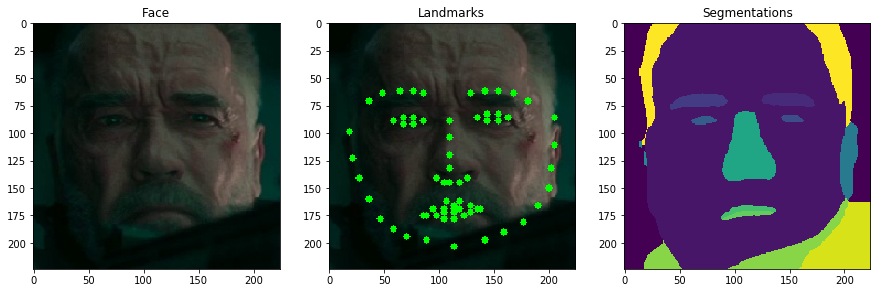

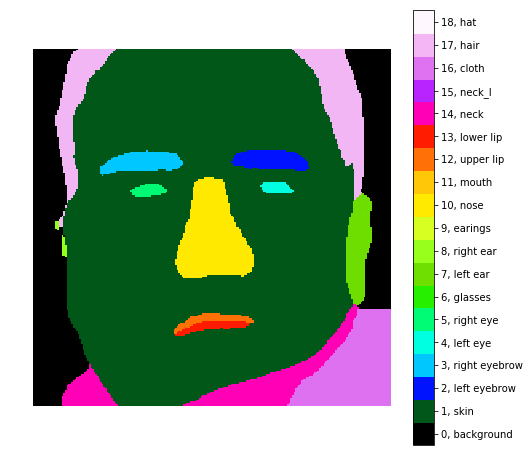

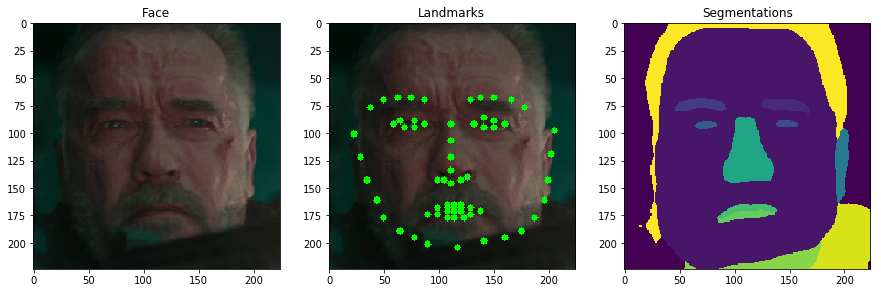

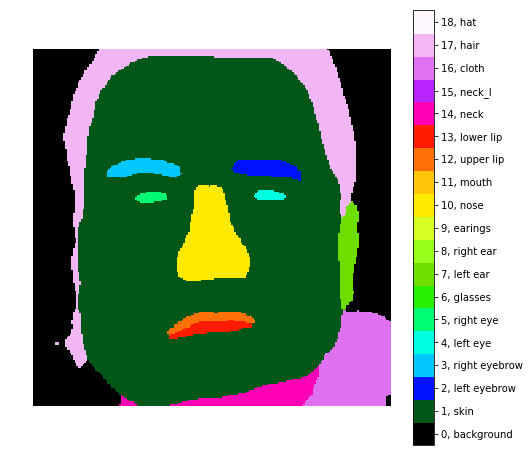

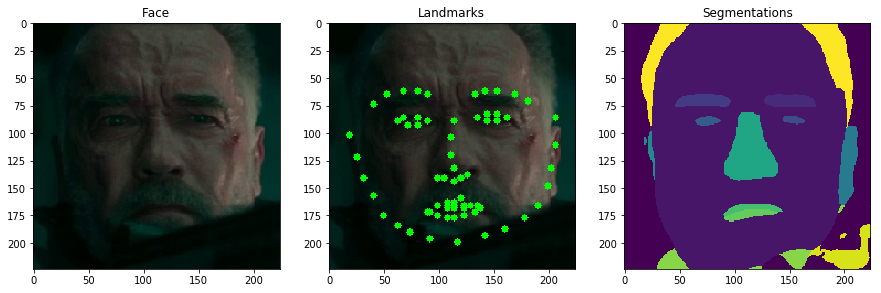

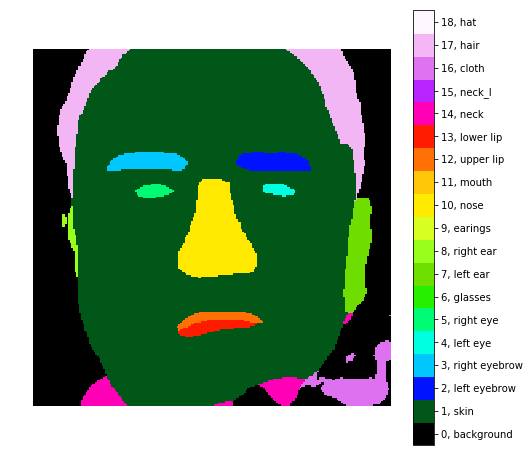

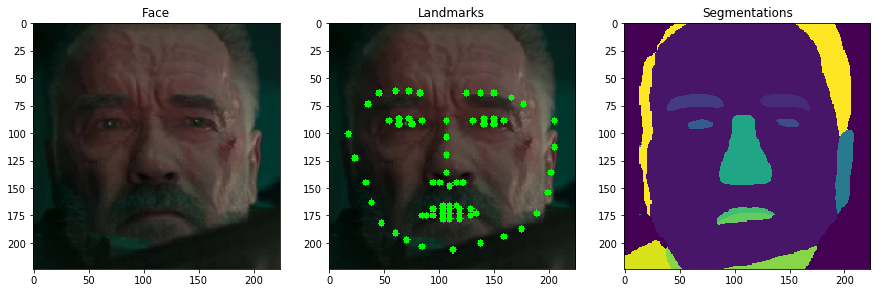

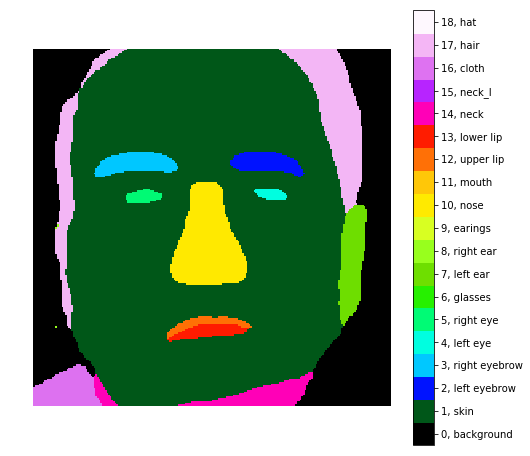

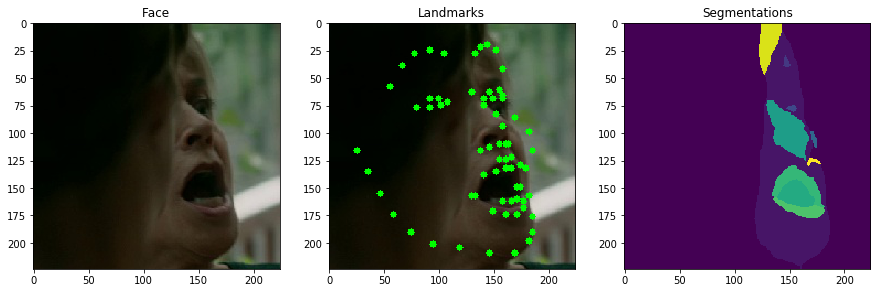

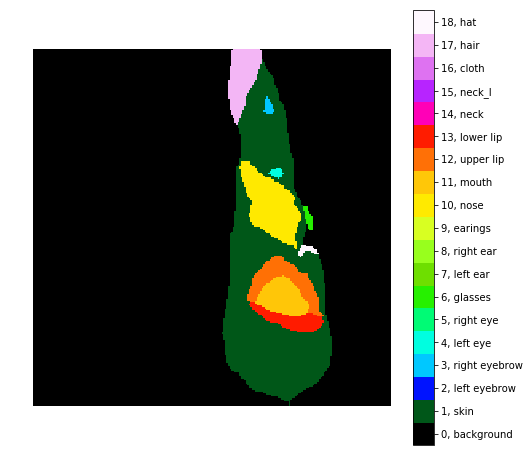

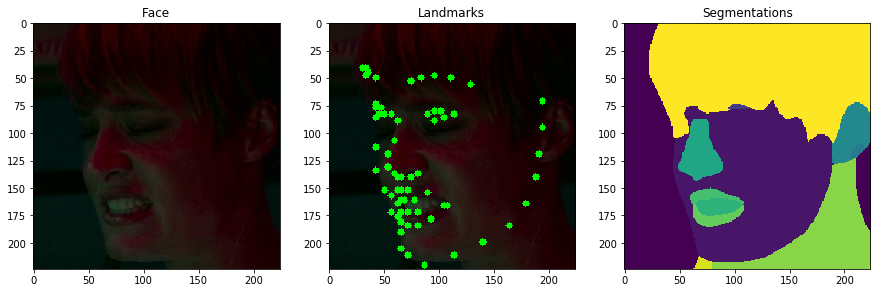

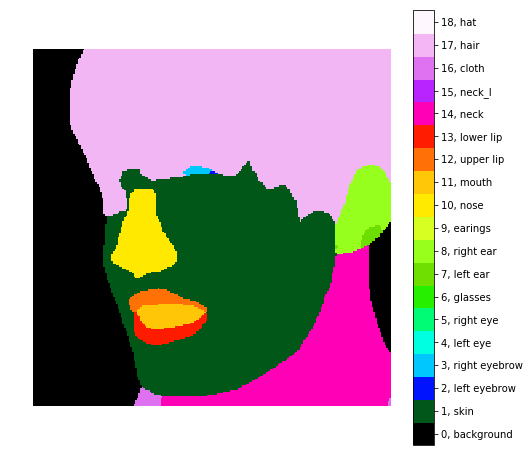

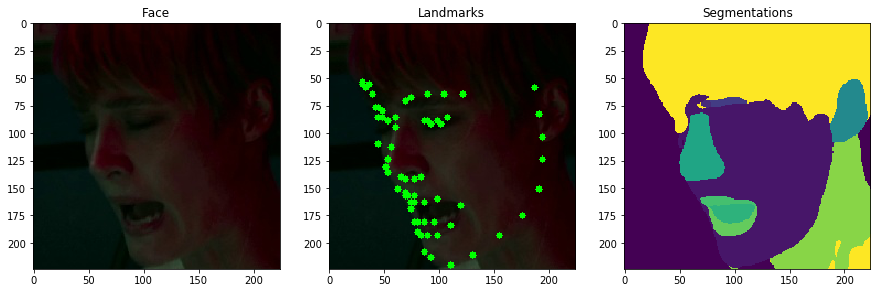

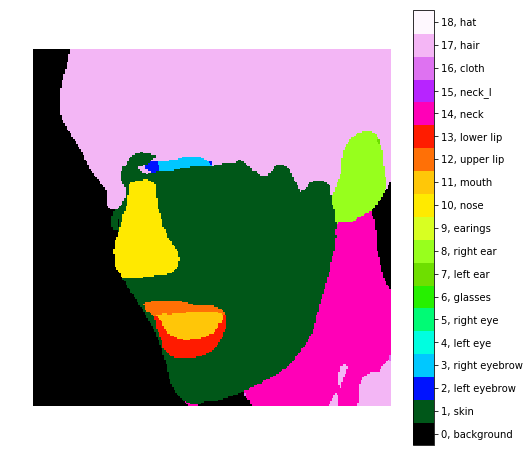

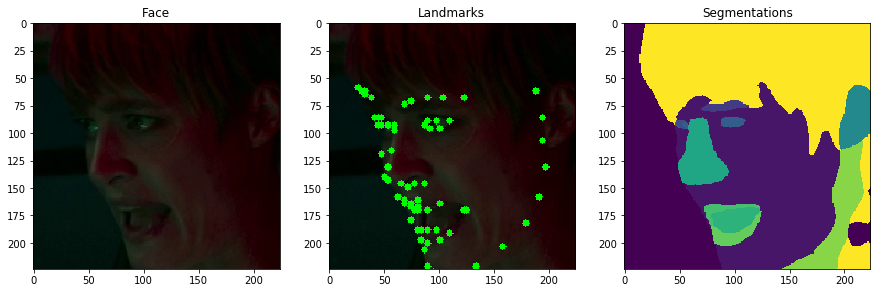

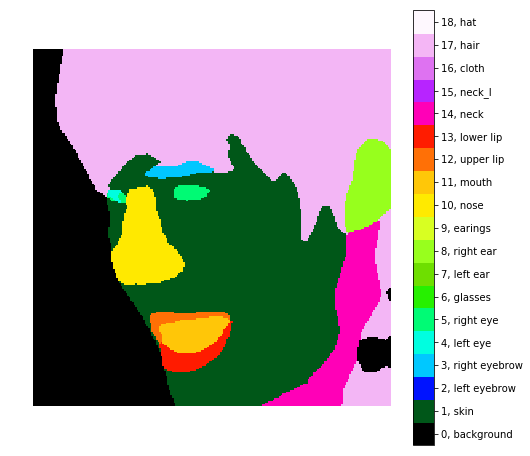

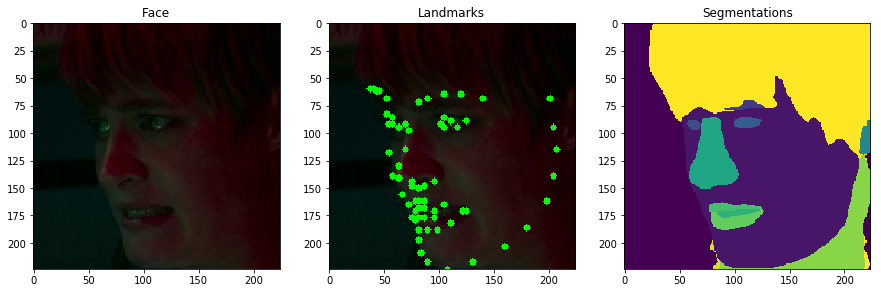

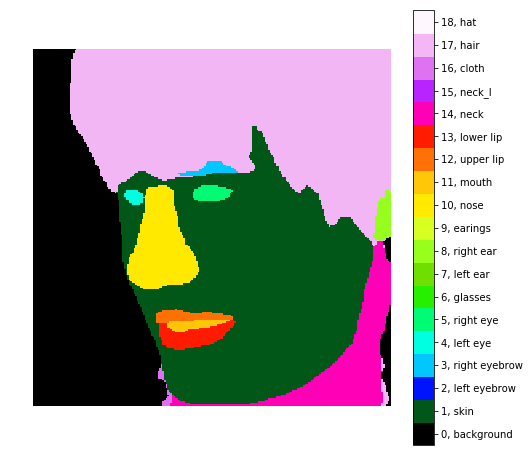

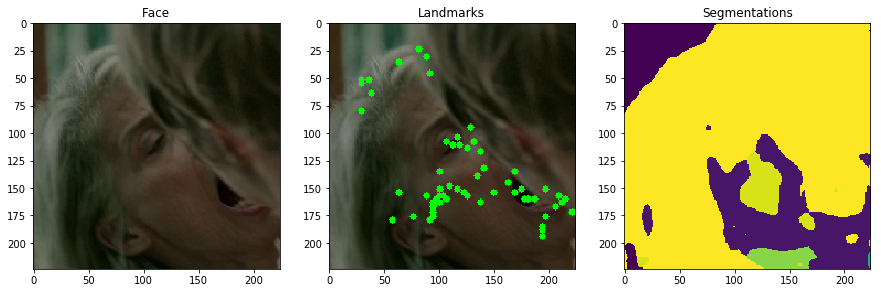

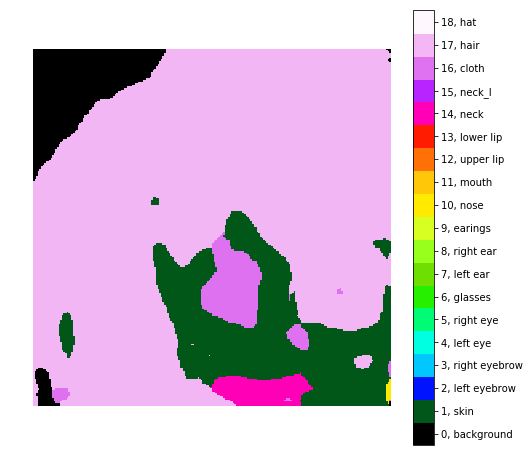

In [0]:
from matplotlib import pyplot
import cv2
import csv
import glob
import numpy as np
import random
from matplotlib.colors import ListedColormap

# Define the class
class FacePositionDataset():
    def __init__(self, csvFilename):
        self.rows = []
        self.csvFilename = csvFilename
    
    def getCSV(self):
      if len(self.rows)>0:
        return self.rows
      with open(self.csvFilename, newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for n, row in enumerate(csv_reader):
          if n> 0:
            self.rows.append(row)
      return self.rows
    
    def preview(self):
      # Get the first 5 rows
      csv = self.getCSV()
      #csv = random.shuffle(csv)
      csv = csv[410:420]
      for row in csv:
        self.displayRow(row)
        self.displaySegmentation(np.load(row[5])[0])
    
    def displayImages(self, images, labels):
      num_faces = len(images)
      pyplot.figure(figsize=(15,6))
      for i in range(num_faces):
        pyplot.subplot(1,3,i+1)
        pyplot.title(labels[i])
        pyplot.imshow(images[i])
    
    def displaySegmentation(self, data):
      parsing_annos = [
        '0, background', '1, skin', '2, left eyebrow', '3, right eyebrow', 
        '4, left eye', '5, right eye', '6, glasses', '7, left ear', '8, right ear', '9, earings',
        '10, nose', '11, mouth', '12, upper lip', '13, lower lip', 
        '14, neck', '15, neck_l', '16, cloth', '17, hair', '18, hat'
      ]
      fig, ax = pyplot.subplots(figsize=(8,8))
      #get discrete colormap
      cmap = pyplot.get_cmap('gist_ncar', len(parsing_annos))
      new_colors = cmap(np.linspace(0, 1, len(parsing_annos)))
      new_colors[0, :] = np.array([0, 0, 0, 1.])
      new_cmap = ListedColormap(new_colors)

      # set limits .5 outside true range
      mat = ax.matshow(data, cmap=new_cmap, vmin=-0.5, vmax=18.5)

      #tell the colorbar to tick at integers    
      cbar = fig.colorbar(mat, ticks=np.arange(0, len(parsing_annos)))
      cbar.ax.set_yticklabels(parsing_annos)
      pyplot.axis('off')
      fig.show()
    
    def draw_landmarks(self, image, landmarks, color=(0, 255, 0), stroke=3):
      for i in range(len(landmarks)): 
        x, y = landmarks[i]
        image = cv2.circle(image.copy(), (int(y), int(x)), stroke, color, -1)        
      return image
    
    def displayRow(self, row):
      # Get the face
      face = pyplot.imread(row[2])
      # Get the landmarks
      landmarks = np.load(row[4])
      # Get the segmentations
      segmentations = np.load(row[5])[0]
      # Display the images
      images = [face, self.draw_landmarks(face, landmarks), segmentations]
      labels = ["Face", "Landmarks", "Segmentations"]
      self.displayImages(images, labels)
      
      
        
        
# Preview the Terminator dataset
dataset = FacePositionDataset(csvFilename="Faces/terminator-dark-fate-trailer-2_h720p/terminator-dark-fate-trailer-2_h720p.csv")
print(dataset.preview())